<a href="https://colab.research.google.com/github/NickPavlovskii/sber/blob/main/sber_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> <font color='green'> Virtual internship Data Science in Sberbank</center> 
 
<img src = "https://avatars.mds.yandex.net/i?id=fe571f0aae6550a77d761e1c53476f39-5190933-images-thumbs&n=13" width = 900 height = 300/>


В файле data_1.csv представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1, то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

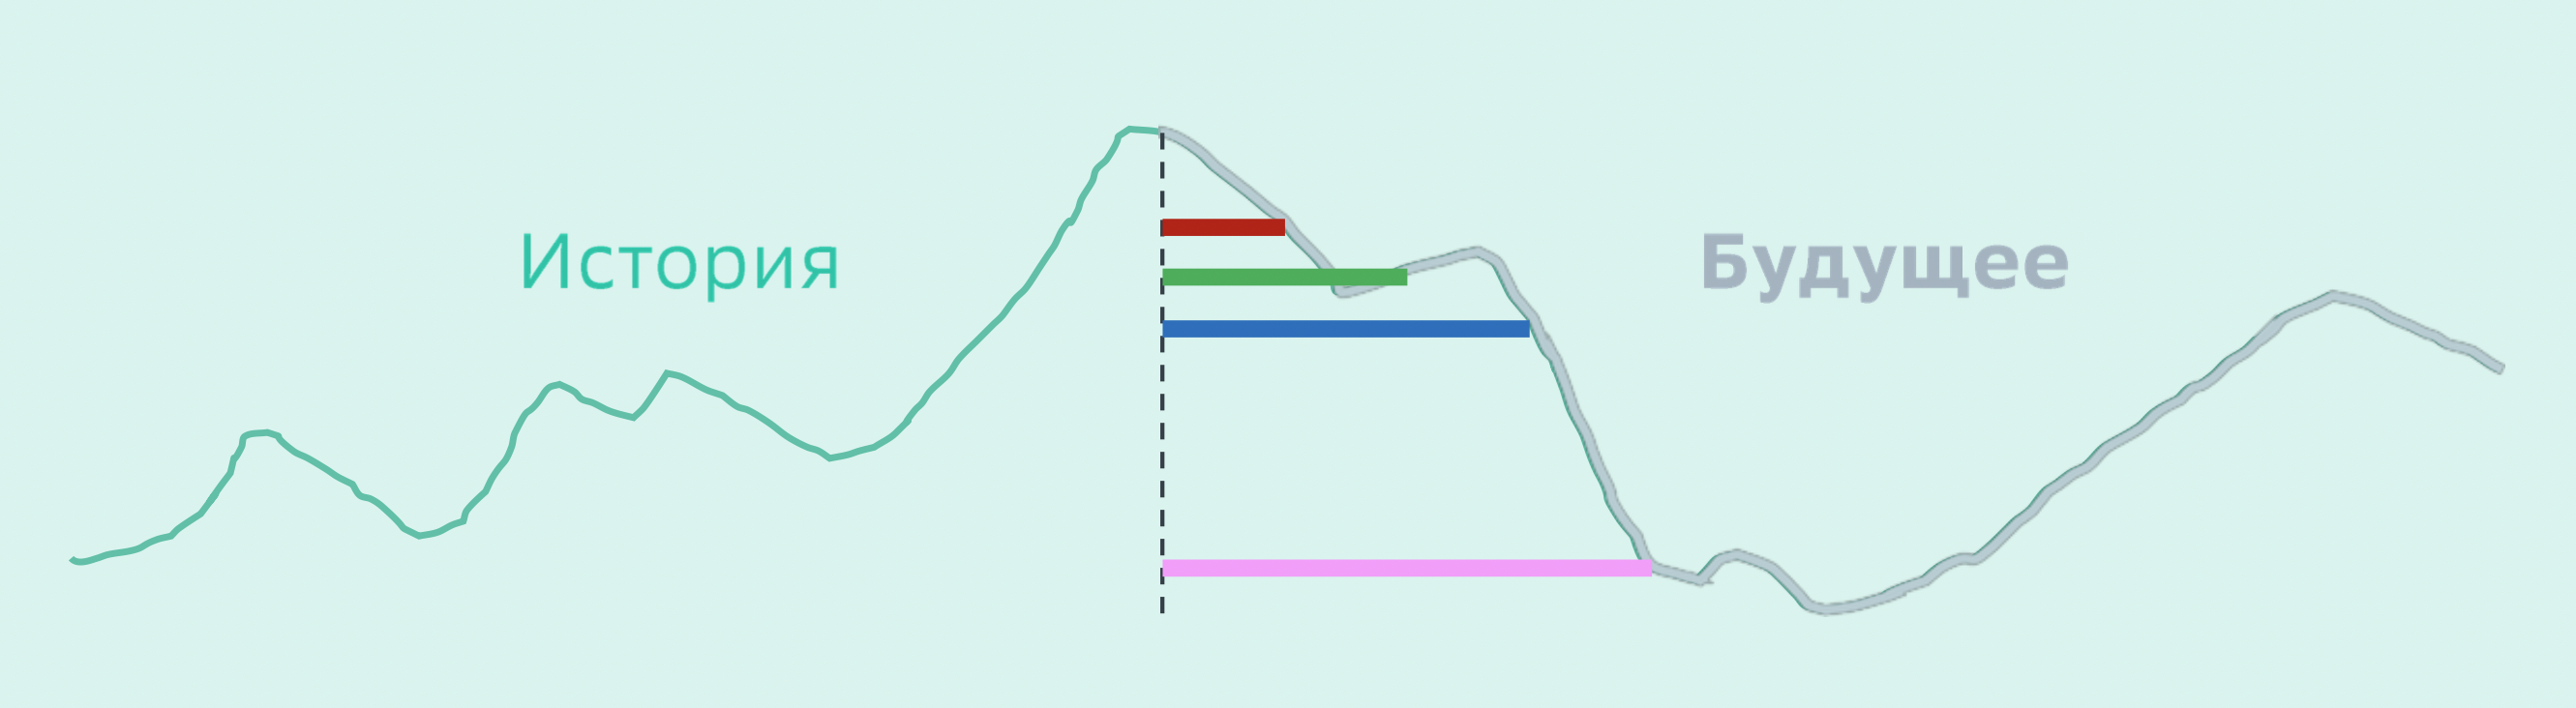

Задача: необходимо построить модель, которая оценивает обьем стабильной части средств на дату.


-  сделать прогноз объема расчетных счетов физических лиц на 1М, 2М, 3М...или др, 
- далее расчитывать минимальное значение объема `value` за данный промежуток. 

То есть после того, как сделал прогноз на промежуток 1 месяц, необходимо определить значение, ниже которого не опускается объема расчетных счетов физических лиц. 




 Оглавление :\
[1. Подготовка данных](#step_0) \
[2. Минимумв месяц(базавое решение)](#step_3) \
[3.Arima ](#Arima )\
[4. SARIMA](#step_2) \
[5. Skforecast](#step_4) \
[6. Обогатим данные](#step_5) \
[7. Лин регрессия](#step_6) \
[8. Лин регрессия 2 (удучшенная версия)](#step_7) \
[9. xgboost](#step_7) \
[10. Решение Сбера](#step_8) \





---






<a id="title-one"></a>
<h1 style='background:#3CB371; border:2; border-radius: 10px; color:black'>
<center>Importing Libraries and Loading Data</center></h1>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# для исследования сезонности, тренда в данных
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn import metrics

from pylab import rcParams

# для теста на стационарность
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.stattools import jarque_bera 

import warnings
import itertools


from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# для форматирования графиков
%matplotlib inline
plt.rcParams.update({'font.size': 15, 
                     'figure.figsize': (18, 8), 
                     'axes.grid' : True})

<a id='step_0'></a>
# Подготовка данных

In [46]:
columns=['Date', 'value']

dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dataset.dropna(subset=['value'], how='all')

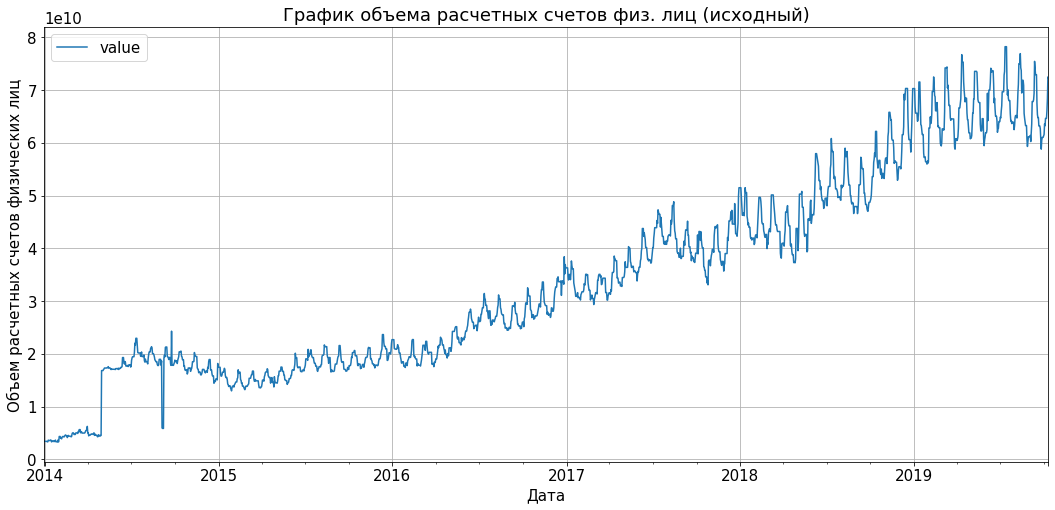

In [47]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц (исходный)')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Проанализировав этот график, можно сделать несколько выводов:

Баланс счета увеличивается к середине месяца, затем падает в течение 10-15 дней и снова начинает расти.
В некоторых точках графика наблюдается небольшое проседание ниже уровня предыдущего пика.
Общая тенденция направлена на увеличение балла, то есть временной ряд не является стационарным, поскольку его математическое ожидание растет со временем.

Попробуем избавиться от выброса во второй половине 2014 года

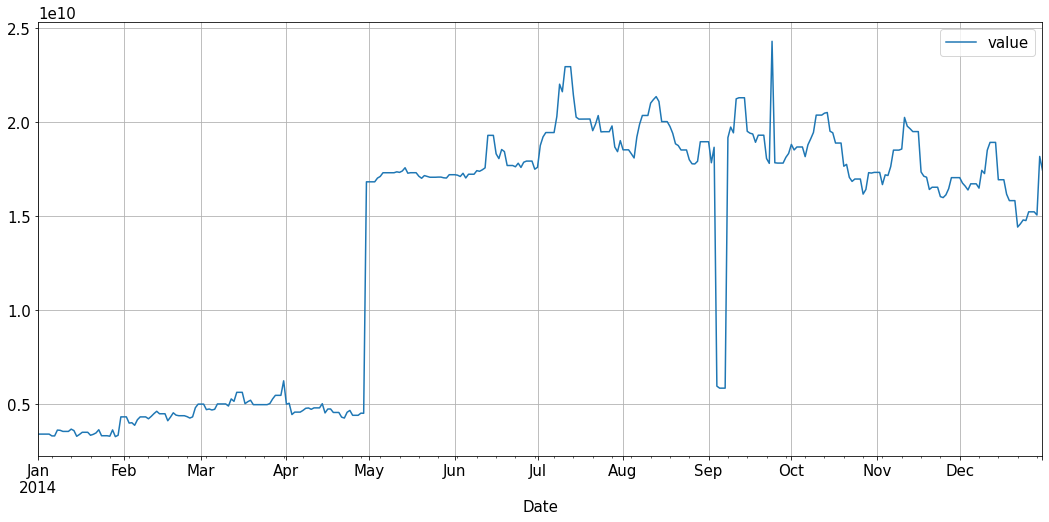

In [48]:
dataset.loc['2014'].plot(y='value');

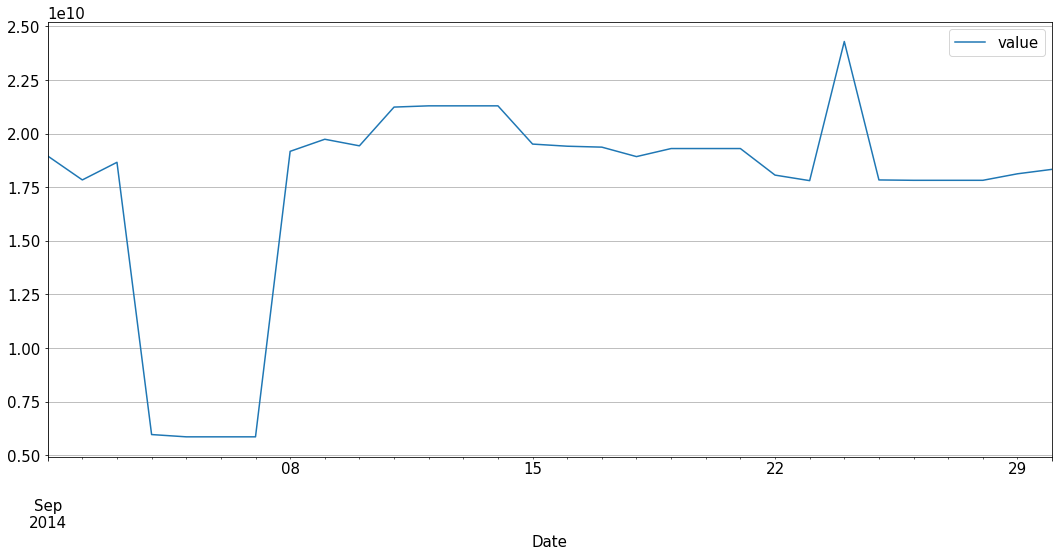

In [49]:
dataset.loc['2014-09'].plot(y='value');

C 04 сентября по 07 сентября 2014 года наблюдается резкий спад объема счетов физ. лиц. Предполагаемой причиной такого резкого спада могло стать подорожание евра,а так же понижения процентов на вкладах. В предполагаемой модели данный фактор не будет учтен, поэтому пока можно удалить данный выброс.

In [50]:
dataset = dataset.drop(['2014-09-04','2014-09-05','2014-09-06','2014-09-07'])


# dataset=dataset.drop(['2014-09-02','2014-09-03','2014-09-04','2014-09-05','2014-09-06','2014-09-07','2014-09-23','2014-09-24','2014-09-25'])


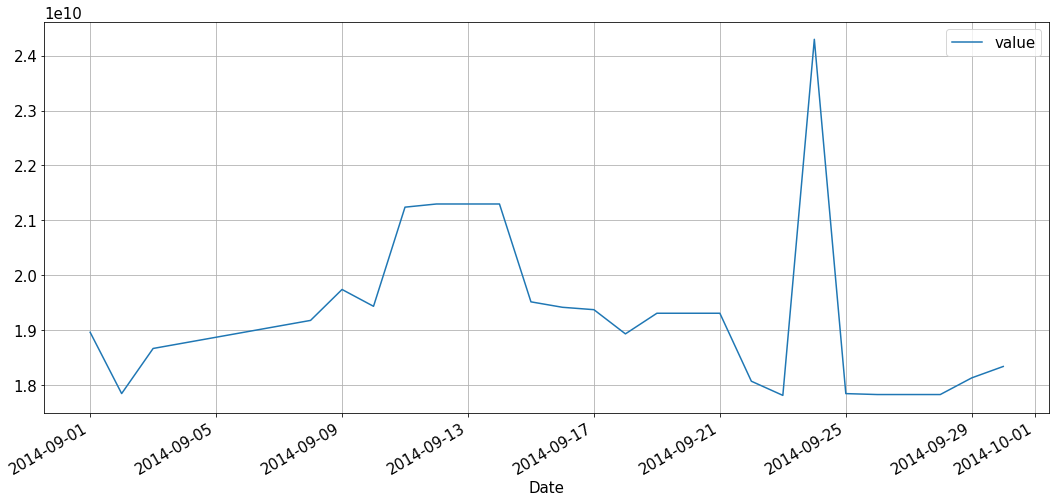

In [51]:
dataset.loc['2014-09'].plot(y='value');

In [52]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2107 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2107 non-null   int64
dtypes: int64(1)
memory usage: 32.9 KB


Пропущенных значений нет

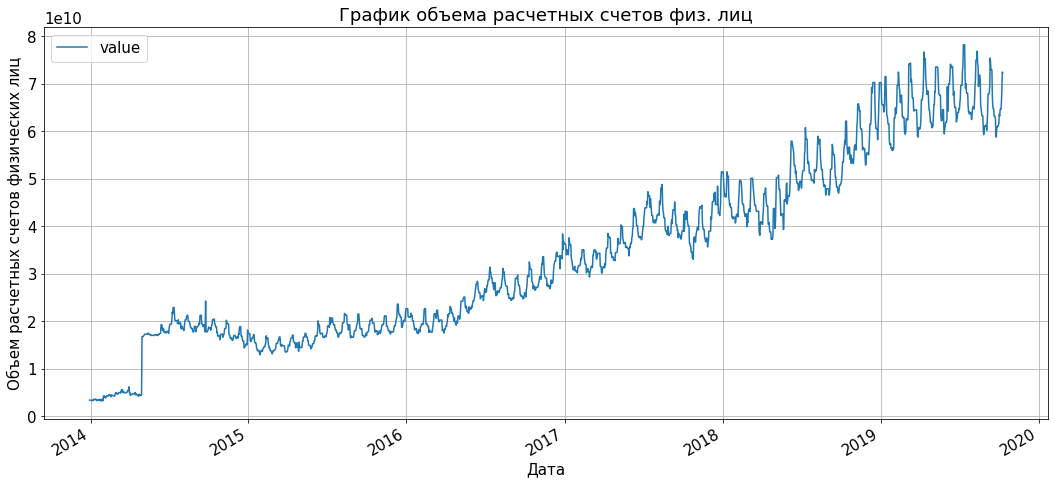

In [53]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

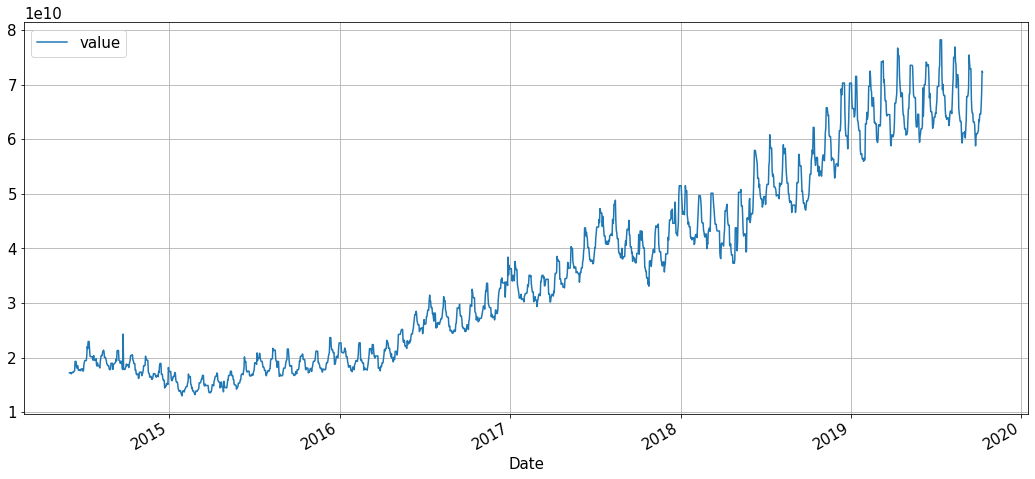

In [54]:
dataset=dataset['2014-06':]
dataset.plot(y='value')

Когда мы создаем прогнозирующую для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой ковариацией, поэтому проведем проверку нашего ряда на стационарность с помощью теста Дики-Фуллера.

- H0 гипотеза: ряд не стационарен 
- H1 гипотеза: ряд стационарен


In [55]:
# Определяем функцию для теста ADF
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(dataset)

Results of Dickey-Fuller Test:
Test Statistic                    0.905860
p-value                           0.993166
Lags Used                        26.000000
Number of Observations Used    1927.000000
Critical Value (1%)              -3.433748
Critical Value (5%)              -2.863041
Critical Value (10%)             -2.567569
dtype: float64


$p_{value} = 0.991880, p_{value} > 0.05$ => p-значение для временного ряда больше 5%, следовательно не удалось опровергунть H0-гипотезу, то есть временной ряд не стационарен.

Видим,что график имеет выбросы. Так анализировать закрытие/открытие счетов за каждые день не имеет смысла, поэтому перейдем к неидеальному интервалу и среднему значению счетов на нем, тем самым уменьшим колебания нашего временного ряда

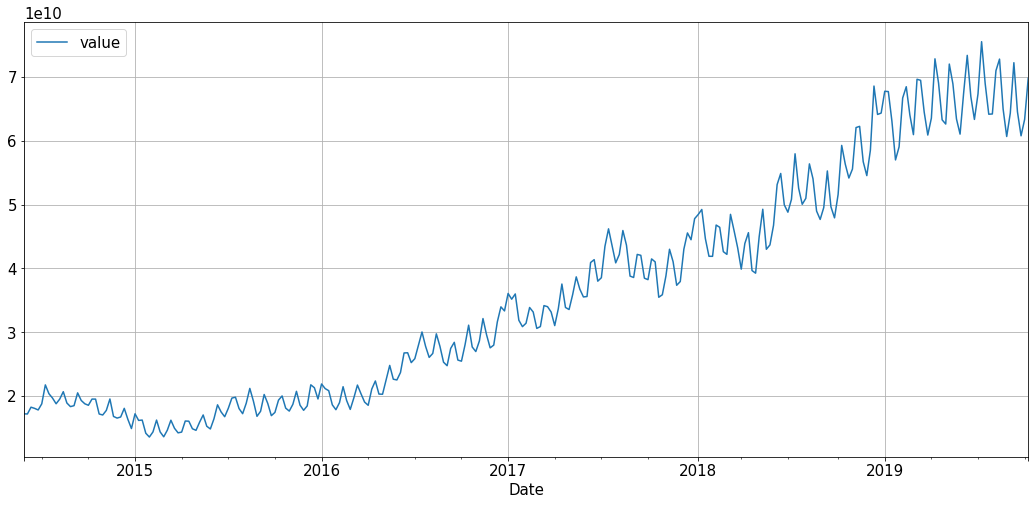

In [56]:
dataset1 = dataset.resample('W').agg('mean')

dataset1.plot(y='value')

In [57]:
dt = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dt.dropna(subset=['value'], how='all')

,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [58]:
dataset1 = dataset1.interpolate()

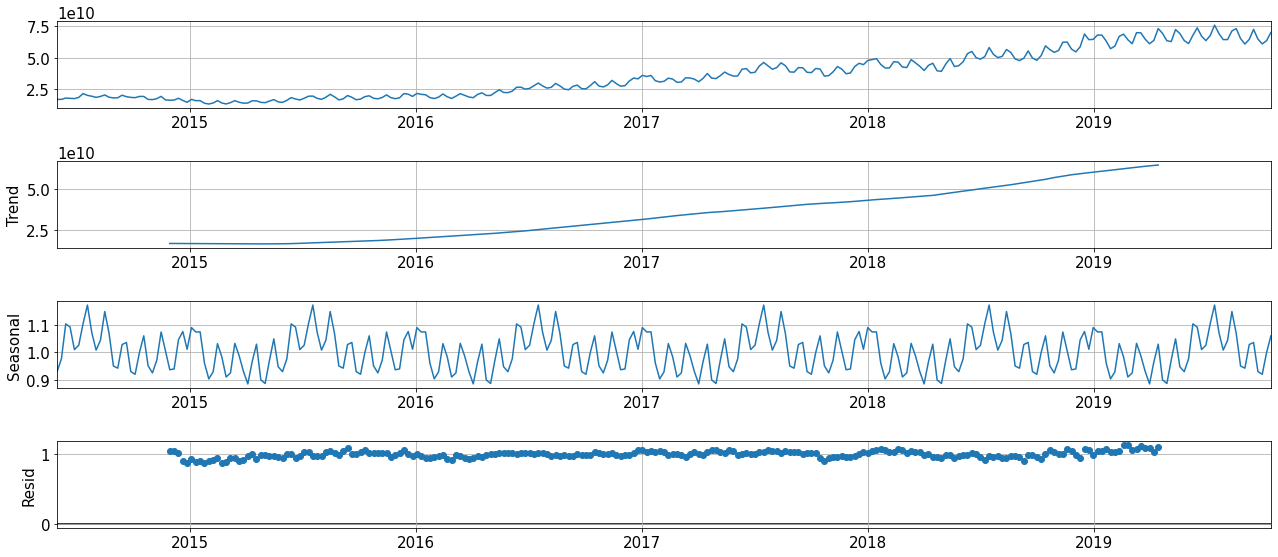

In [59]:
ts_dicomposition = seasonal_decompose(dataset1, model='multiplicate')
ts_dicomposition.plot();

Временные ряды [стационарный](https://en.wikipedia.org/wiki/Stationary_process) если они не имеют тенденции или сезонных эффектов. Наблюдения в стационарном временном ряду не зависят от времени. 

В нашем же случае можно выделить тренд и сезонность, значит ряд нестационарен

,value
count,2.810000e+02
mean,3.601341e+10
std,1.775968e+10
min,1.356953e+10
25%,1.930714e+10
50%,3.317428e+10
75%,4.882917e+10
max,7.556869e+10


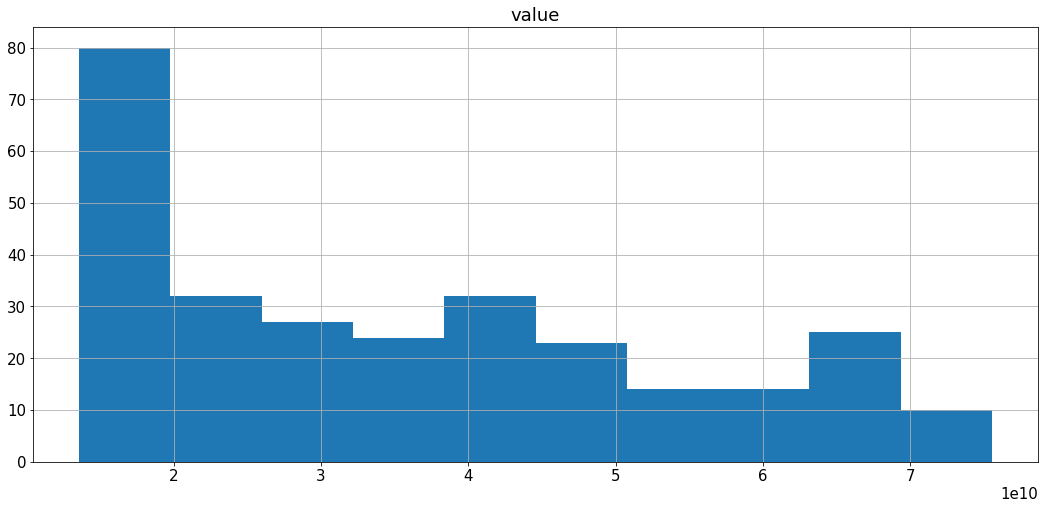

In [60]:
itog = dataset1.describe()
dataset1.hist()
itog

Можно предположить, что это логнормальное [распределение](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

Функция логарифма часто используется для моделей в экономике (например, модель спроса в ценообразование может быть описана логарифмом). Поэтому прологарифмируем наше значение, чтобы посмотреть на распределение логарифма величины.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03ce18e990>]],
      dtype=object)

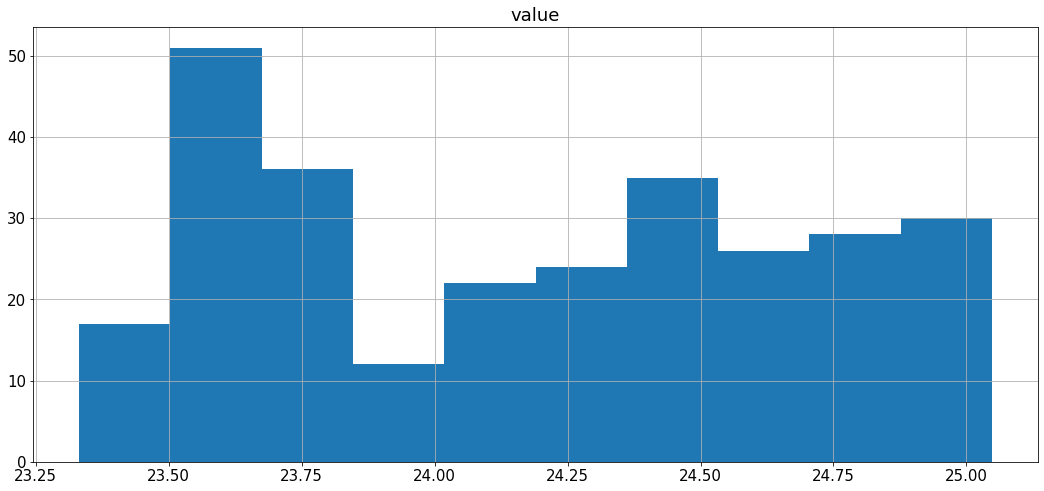

In [61]:
dataset1_log = np.log(dataset1)
dataset1_log.hist()

Прологарифмировав величину и построив гистограмму, получилось бимодальное распределение.

Заметим не однородный график. Посчитаем коэффициент вариации.

In [62]:
row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataset1)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)


          JB         
---------------------
    24.84086279256591
4.035294000646516e-06
   0.5373911747999228
   2.0169016184756328
---------------------


In [63]:
test = sm.tsa.adfuller(dataset1)

print(f'adf: {test[0]}') # может стоит использовать f-strings - форматирование строк
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд нестационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf: 1.1563885231724627
p-value:  0.9956702740792251
Critical values:  {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
есть единичные корни, ряд нестационарен


In [64]:
otgdiff = dataset1.diff(periods=1).dropna()

In [65]:
test = sm.tsa.adfuller(otgdiff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])

if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else: 
    print('единичных корней нет,ряд стационарный')
    

adf: -5.889377276673699
p-value: 2.949125111743946e-07
Critical values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
единичных корней нет,ряд стационарный


Построим график и посмотрим на тренд для графика. 

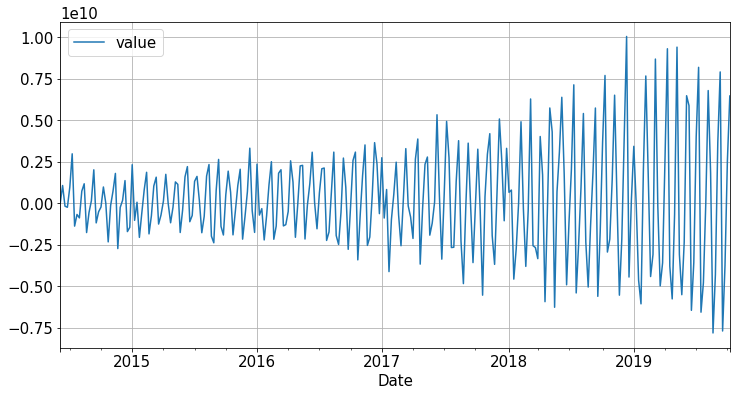

In [66]:
otgdiff.plot(figsize=(12,6))

Видим что тренда нет и таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

Проведем небольшой анализ и посмотрим диаграмму рассеяния в зависимости от года, дня, месяца и дня недели.

In [68]:
dtA=dt
dtA


,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [73]:

dtA.loc[:, 'date'] = dtA.index
dtA.loc[:, 'dayofweek'] = dtA['date'].dt.dayofweek
dtA.loc[:, 'quarter'] = dtA['date'].dt.quarter
dtA.loc[:, 'month'] = dtA['date'].dt.month
dtA.loc[:, 'year'] = dtA['date'].dt.year
dtA.loc[:, 'dayofyear'] = dtA['date'].dt.dayofyear
dtA.loc[:, 'dayofmonth'] = dtA['date'].dt.day
dtA.loc[:, 'weekofyear'] = dtA['date'].dt.weekofyear
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [74]:
import plotly.express as px
fig = px.scatter(dtA, x='year',y='value')
fig.update_layout(title="Values by years")
fig.show()

In [76]:
fig = px.scatter(dtA, x='month',y='value')
fig.update_layout(title="Values by month")
fig.show()

In [78]:
fig = px.scatter(dtA, x='dayofmonth',y='value')
fig.update_layout(title="Values by day")
fig.show()

Выводы из проведенного анализа визуализации:

 * значения увеличиваются в 2019 году
 * значения увеличиваются к середине года и падают к концу
 * С 10-го по 15-е число заметно увеличение баланса счета.
 * максимальные значения по выходным и средам.

# Минимум в месяц(baseline decision)


предскажем минимальное значение объема,при подготовке обучающих данных при группировке по месяцу возьмем минимальные значения.

$$ mint \in time(value0..valuet) $$ 











In [ ]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dataset.dropna(subset=['value'], how='all')

,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [ ]:
df_min = dataset1.groupby(pd.Grouper(axis=0, freq='m')).min()

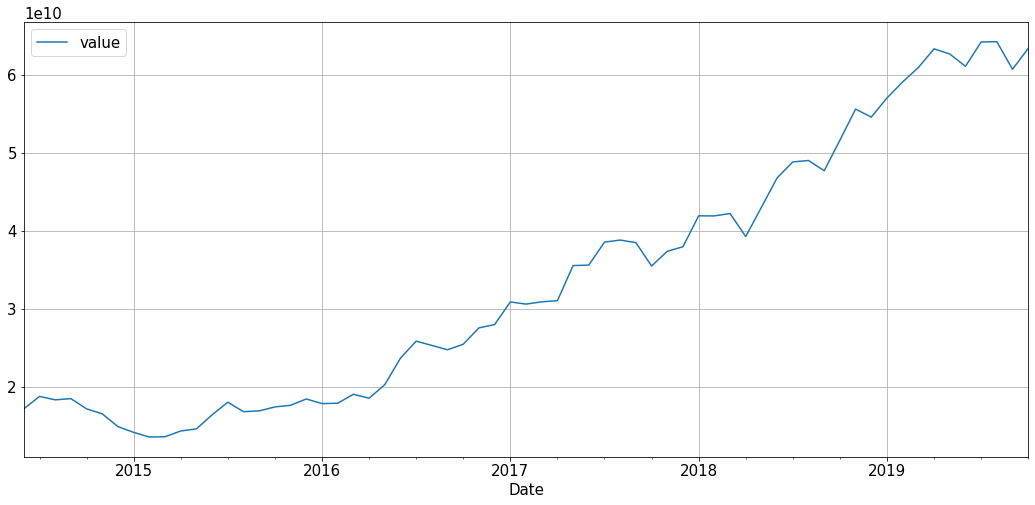

In [ ]:
df_min.plot(y='value');

Train dates : 2014-06-30 00:00:00 --- 2019-05-31 00:00:00  (n=60)
Test dates  : 2019-06-30 00:00:00 --- 2019-10-31 00:00:00  (n=5)


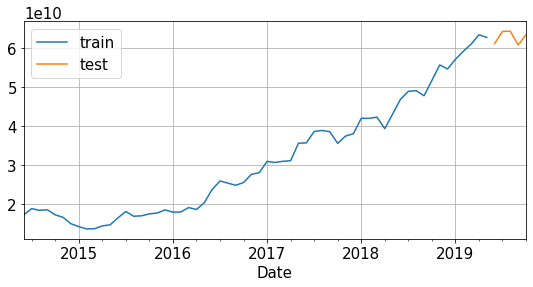

In [ ]:
steps = 5
data_train = df_min[:-steps]
data_test  = df_min[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
def create_features(df_min, label=None):
    """
    Creates time series features from datetime index
    """
    df_min.loc[:, 'date'] = df_min.index
    df_min.loc[:,'dayofweek'] = df_min['date'].dt.dayofweek
    df_min.loc[:, 'quarter'] = df_min['date'].dt.quarter
    df_min.loc[:, 'month'] = df_min['date'].dt.month
    df_min.loc[:, 'year'] = df_min['date'].dt.year
    df_min.loc[:, 'dayofyear'] = df_min['date'].dt.dayofyear
    df_min.loc[:, 'dayofmonth'] = df_min['date'].dt.day
    df_min.loc[:, 'weekofyear'] = df_min['date'].dt.weekofyear
    
    X = df_min[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_min[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


Попробуем лин регрессию

In [ ]:
feature_name = X_train.columns

scalerX = StandardScaler()
scalerX.fit(X_train) 
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

scalerY = StandardScaler()
scalerY.fit(y_train.values.reshape(-1, 1)) 
y_train = scalerY.transform(y_train.values.reshape(-1, 1))
y_test = scalerY.transform(y_test.values.reshape(-1, 1))

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_

sorted(list(zip(feature_name, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek', array([  0.02113011,   0.14869512,  16.42226233,   0.98132621,
         -16.31621334,   0.05390508,  -0.07994223]))]

In [ ]:
pd.DataFrame({
    'variable': feature_name,
    'importance': model.coef_[0] 
}) \
  .round(decimals=2)\
  .sort_values('importance',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,importance
2,month,16.420000
3,year,0.980000
1,quarter,0.150000
5,dayofmonth,0.050000
0,dayofweek,0.020000
6,weekofyear,-0.080000
4,dayofyear,-16.320000


In [ ]:
y_predict = model.predict(X_test)
y_predict

array([[1.75094091],
       [1.83279452],
       [1.79593187],
       [1.75830687],
       [1.91986416]])

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 0.1097536225261363
Root Mean Squared Error: 0.33129084280453075
Mean Absolute Error: 0.3209270217351125
R2 -9.230404614247766


In [ ]:
y_predict = scalerY.inverse_transform(y_predict)

In [ ]:
for_sub = pd.DataFrame(y_predict, index=data_test.index)
for_sub = for_sub.rename({0:'min_value_pred'}, axis=1)

for_sub.min_value_pred = for_sub.min_value_pred.round().astype('int')

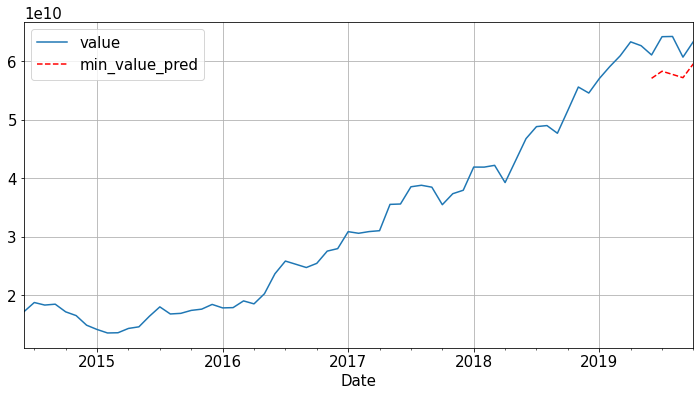

In [ ]:
ax = df_min.plot(figsize=(12,6))
for_sub.plot(style='r--', ax=ax);

Попробуем xgboost

In [ ]:
#!pip install xgboost

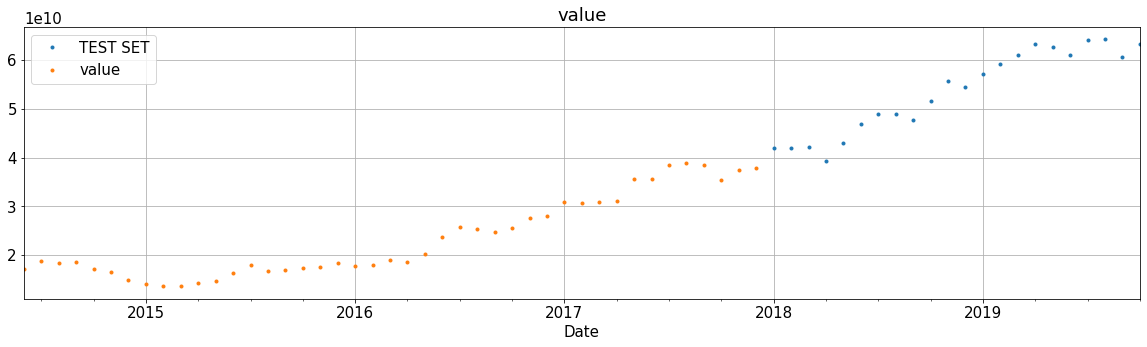

In [ ]:
temp = df_min[['value']]
split_date = '2018-01'

temp_train = temp.loc[temp.index <= split_date].copy()
temp_test = temp.loc[temp.index > split_date].copy()

_ = temp_test.rename(columns={'value': 'TEST SET'})\
    .join(temp_train.rename(columns={'valueP': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='value', style='.')

In [ ]:
import xgboost as xgb

In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [ ]:
regressor.fit(X_train, y_train)

[15:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('R2', r2_score(y_test, y_pred))

Mean Squared Error: 0.0098365447872141
Root Mean Squared Error: 0.0991793566586016
Mean Absolute Error: 0.09011173153316147
R2 0.08311151046148046


In [ ]:
for_sub1 = pd.DataFrame(y_pred, index=data_test.index)
for_sub1 = for_sub.rename({0:'min_value_pred'}, axis=1)

for_sub1.min_value_pred = for_sub1.min_value_pred.round().astype('int')

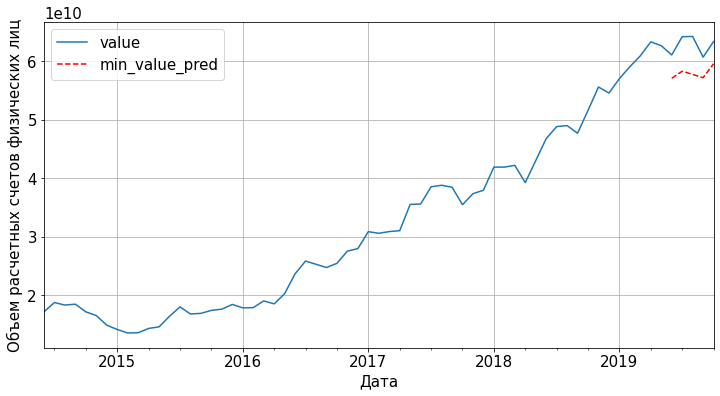

In [ ]:
ax = df_min.plot(figsize=(12,6))
for_sub1.plot(style='r--', ax=ax);
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Попробуем рассмотреть сезонность и тренд 

In [ ]:
def combine_seasonal_cols(input_df, seasonal_model_results):
   
    
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

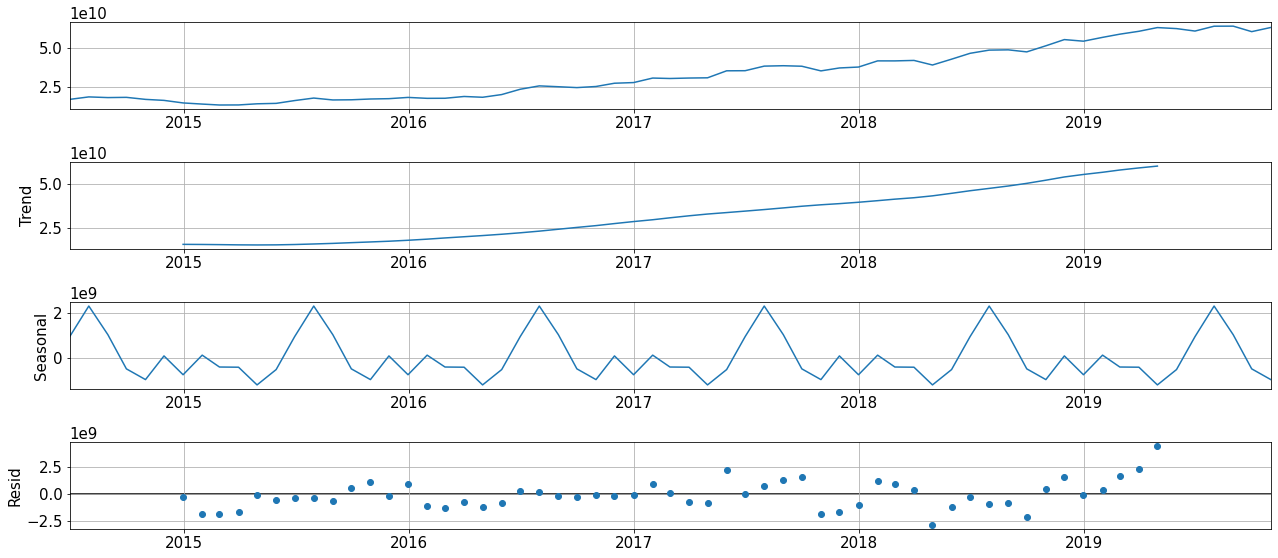

In [ ]:
sd = seasonal_decompose(df_min, period=12)

sd.plot();


In [ ]:
combine_seasonal_cols(df_min, sd) 
df_min

,value,observed,residual,seasonal,trend
Date,,,,,
2014-06-30,1.718698e+10,1.718698e+10,NaN,9.484297e+08,NaN
2014-07-31,1.877395e+10,1.877395e+10,NaN,2.283024e+09,NaN
2014-08-31,1.833824e+10,1.833824e+10,NaN,1.031707e+09,NaN
2014-09-30,1.848882e+10,1.848882e+10,NaN,-4.579681e+08,NaN
2014-10-31,1.718025e+10,1.718025e+10,NaN,-9.262687e+08,NaN
...,...,...,...,...,...
2019-06-30,6.107306e+10,6.107306e+10,NaN,9.484297e+08,NaN
2019-07-31,6.419393e+10,6.419393e+10,NaN,2.283024e+09,NaN
2019-08-31,6.423243e+10,6.423243e+10,NaN,1.031707e+09,NaN


In [ ]:
df_train_M = df_min[:'2018-01-05']
df_test_M = df_min['2018-01-05':]

In [ ]:
def create_features(df_min, label=None):
    """
    Creates time series features from datetime index
    """
    df_min.loc[:, 'date'] = df_min.index
    df_min.loc[:,'dayofweek'] = df_min['date'].dt.dayofweek
    df_min.loc[:, 'quarter'] = df_min['date'].dt.quarter
    df_min.loc[:, 'month'] = df_min['date'].dt.month
    df_min.loc[:, 'year'] = df_min['date'].dt.year
    df_min.loc[:, 'dayofyear'] = df_min['date'].dt.dayofyear
    df_min.loc[:, 'dayofmonth'] = df_min['date'].dt.day
    df_min.loc[:, 'weekofyear'] = df_min['date'].dt.weekofyear
    
    x =  df_min[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','observed','residual','seasonal','trend']]
    if label:
        y = df_min[label]
        return x, y
    return x



In [ ]:
X_train_M, y_train_M = create_features(df_train_M, label='value')
X_test_M, y_test_M = create_features(df_test_M, label='value')


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [ ]:
X_train_M = X_train_M[X_train_M.residual.notnull()]
y_train_M = y_train_M["2014-12-31":]


X_test_M = X_test_M[X_test_M.residual.notnull()]
y_test_M = y_test_M["2019-01-31":]

In [ ]:
model = LinearRegression()
model.fit(X_train_M, y_train_M) 
importance = model.coef_
sorted(list(zip(X_train_M.columns, importance)), 
       key=lambda x: abs(x[1]))

[('weekofyear', -3.7674683402366684e-09),
 ('dayofweek', -2.1251646272304572e-08),
 ('dayofmonth', 8.269207247031221e-07),
 ('dayofyear', -8.407170108763069e-07),
 ('quarter', -1.365969228894759e-06),
 ('year', 5.426849989406968e-06),
 ('month', 2.6194739009464057e-05),
 ('trend', 0.2500000000836271),
 ('seasonal', 0.2500000000836281),
 ('residual', 0.2500000000836283),
 ('observed', 0.7499999999163716)]

In [ ]:
pd.DataFrame({
    'variable': X_train_M.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
7,observed,0.750000
8,residual,0.250000
9,seasonal,0.250000
10,trend,0.250000
0,dayofweek,-0.000000
1,quarter,-0.000000
2,month,0.000000
3,year,0.000000
4,dayofyear,-0.000000
5,dayofmonth,0.000000


In [ ]:
y_predict = model.predict(X_test_M)
y_predict

array([4.19157458e+10, 4.19083050e+10, 4.22124448e+10, 3.92657056e+10,
       4.30150781e+10, 4.67767535e+10, 4.88291723e+10, 4.90071763e+10,
       4.76941555e+10, 5.16086521e+10, 5.55958234e+10, 5.45653423e+10,
       5.70267347e+10, 5.90767327e+10, 6.09262401e+10, 6.33124336e+10])

In [ ]:
y_test_M

Date
2019-01-31    5.702673e+10
2019-02-28    5.907673e+10
2019-03-31    6.092624e+10
2019-04-30    6.331243e+10
2019-05-31    6.265431e+10
2019-06-30    6.107306e+10
2019-07-31    6.419393e+10
2019-08-31    6.423243e+10
2019-09-30    6.069904e+10
2019-10-31    6.337633e+10
Freq: M, Name: value, dtype: float64

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(X_test_M, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(X_test_M, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(X_test_M, y_predict)) 
print('R2', r2_score(X_test_M,y_predict))


ValueError: ignored

In [ ]:
for_sub = pd.DataFrame(model.predict(X_test_M), index=X_test_M.index)
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

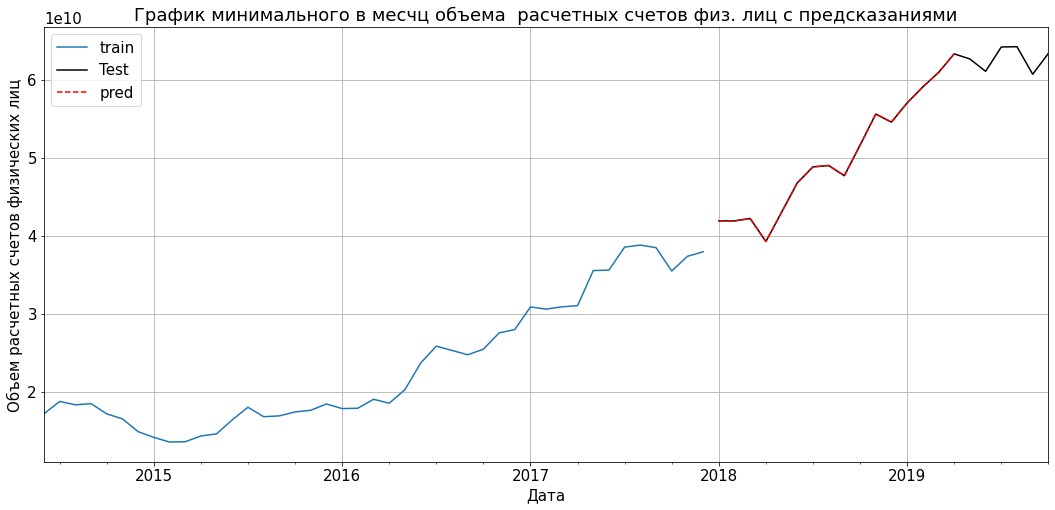

In [ ]:
df_train_M['value'].plot(label='train',title='График минимального в месчц объема  расчетных счетов физ. лиц c предсказаниями')
df_test_M['value'].plot(style='black',label='Test')
ax=for_sub['value_pred'].plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");



Как предсказать на сколько то вперед??

<a id='Arima '></a>

# Arima 

**Построение модели** 


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

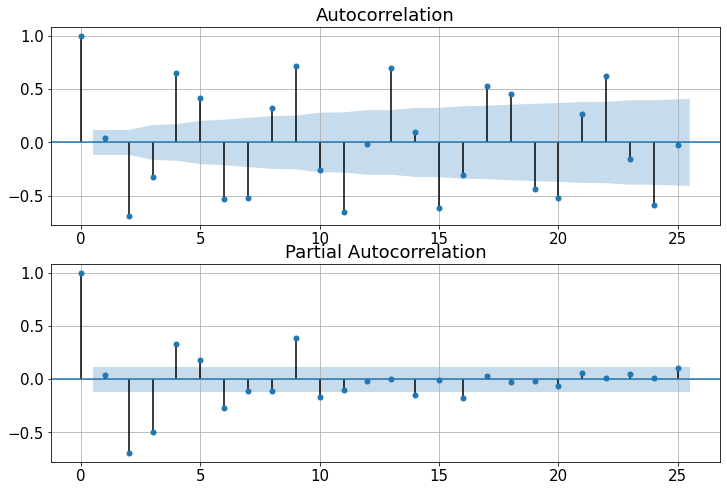

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otgdiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otgdiff, lags=25, ax=ax2)

In [ ]:
src_data_model = dataset1[:'2019-06-10']
model = sm.tsa.ARIMA(src_data_model, order=(3, 2, 2), freq='W').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

In [ ]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  261
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -5963.611
Method:                       css-mle   S.D. of innovations     5316477343.779
Date:                Sun, 09 Oct 2022   AIC                          11941.222
Time:                        21:31:22   BIC                          11966.174
Sample:                    06-15-2014   HQIC                         11951.252
                         - 06-09-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.488e+07        nan        nan        nan         nan         nan
ar.L1.D2.value    -0.4082        nan        nan        nan         nan         nan
ar.L2.D2.value    -0.8344   7.76e-06

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [ ]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [ ]:
pred = model.predict('2019-05-26','2020-01-31', typ='levels')
trn = dataset1['2019-05-26':]
r2 = r2_score(trn, pred[0:len(trn)])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(trn, pred[0:len(trn)]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trn, pred[0:len(trn)])))
print('Mean Absolute Error:', metrics.mean_absolute_error(trn, pred[0:len(trn)])) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


R^2: 0.68
Mean Squared Error: 5.852871791632091e+18
Root Mean Squared Error: 2419270921.5034375
Mean Absolute Error: 2112605309.9783275


Попробуем предсказать...

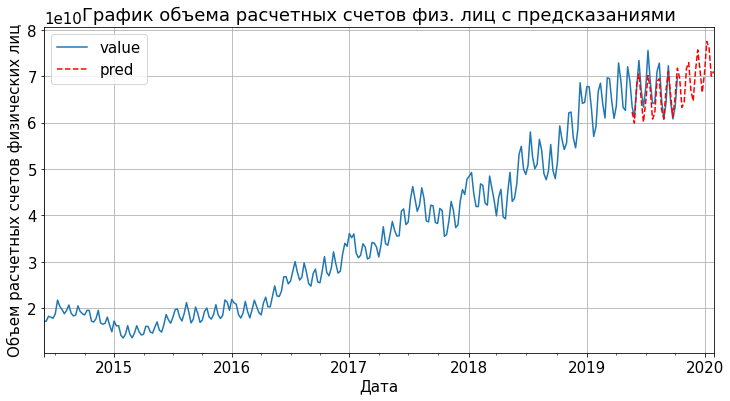

In [ ]:
dataset1.plot(figsize=(12,6), title='График объема расчетных счетов физ. лиц c предсказаниями')
ax=pred.plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

In [ ]:
dt_pred=dataset1['2019-05-15':]


dt_pred['pred']=pred
dt_pred.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,value,pred
Date,,
2019-05-19,6.896488e+10,NaN
2019-05-26,6.344489e+10,6.232079e+10
2019-06-02,6.107306e+10,5.991039e+10
2019-06-09,6.754772e+10,6.824427e+10
2019-06-16,7.342399e+10,7.051774e+10
2019-06-23,6.696145e+10,6.501986e+10
2019-06-30,6.337888e+10,6.014138e+10
2019-07-07,6.738229e+10,6.445840e+10
2019-07-14,7.556869e+10,7.016113e+10


# SARIMA

Попробуем  предсказать ряд с помощью SARIMA

In [ ]:
df=dataset1

In [ ]:
def combine_seasonal_cols(input_df, seasonal_model_results):
   
    
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

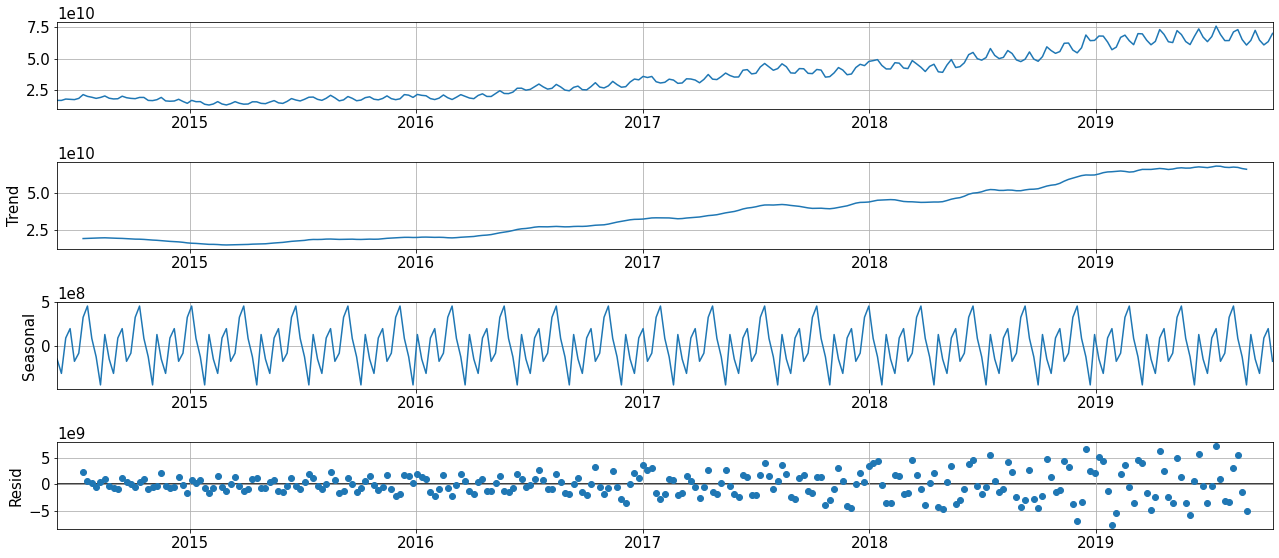

In [ ]:
sd = seasonal_decompose(df, period=12)

sd.plot();


In [ ]:
combine_seasonal_cols(df, sd) 

In [ ]:
df

,value,observed,residual,seasonal,trend
Date,,,,,
2014-06-01,1.720682e+10,1.720682e+10,NaN,-1.505831e+08,NaN
2014-06-08,1.718698e+10,1.718698e+10,NaN,-3.147291e+08,NaN
2014-06-15,1.824927e+10,1.824927e+10,NaN,9.197979e+07,NaN
2014-06-22,1.806436e+10,1.806436e+10,NaN,1.989678e+08,NaN
2014-06-29,1.781468e+10,1.781468e+10,NaN,-1.760293e+08,NaN
...,...,...,...,...,...
2019-09-15,7.227318e+10,7.227318e+10,NaN,-1.505831e+08,NaN
2019-09-22,6.456505e+10,6.456505e+10,NaN,-3.147291e+08,NaN
2019-09-29,6.080820e+10,6.080820e+10,NaN,9.197979e+07,NaN


In [ ]:
df_train_S = df[:'2019-01-05']
df_test_S = df['2019-01-05':]

In [ ]:
df_train_S['trend_plus_resid'] = df_train_S['trend'] + df_train_S['residual']
df_train_S = df_train_S[df_train_S.trend_plus_resid.notnull()]

df_test_S['trend_plus_resid'] = df_test_S['trend'] +df_test_S['residual']
df_test_S = df_test_S[df_test_S.trend_plus_resid.notnull()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_train_S['value'],order=(3, 1,2 ),seasonal_order=(3,2,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


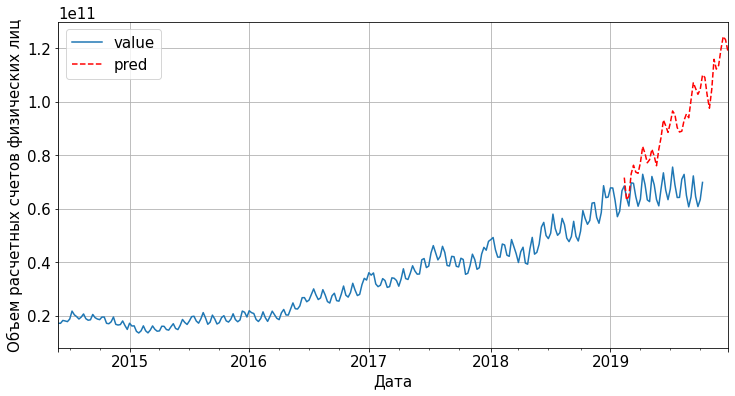

In [ ]:
df['value'].plot(figsize=(12,6))
ax=results.predict(start=240,end=285,dynamic=True).plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

In [ ]:
df_test_S['pred']=pred
df_test_S

,value,observed,residual,seasonal,trend,trend_plus_resid,pred
Date,,,,,,,
2019-01-06,6.779765e+10,6.779765e+10,5.082979e+09,-1.505831e+08,6.286525e+10,6.794823e+10,NaN
2019-01-13,6.774500e+10,6.774500e+10,4.307745e+09,-3.147291e+08,6.375198e+10,6.805973e+10,NaN
2019-01-20,6.309811e+10,6.309811e+10,-1.243539e+09,9.197979e+07,6.424966e+10,6.300613e+10,NaN
2019-01-27,5.702673e+10,5.702673e+10,-7.567385e+09,1.989678e+08,6.439515e+10,5.682777e+10,NaN
2019-02-03,5.907673e+10,5.907673e+10,-5.409794e+09,-1.760293e+08,6.466256e+10,5.925276e+10,NaN
2019-02-10,6.674185e+10,6.674185e+10,1.932487e+09,-8.249434e+07,6.489186e+10,6.682435e+10,NaN
2019-02-17,6.850709e+10,6.850709e+10,3.566142e+09,3.291297e+08,6.461182e+10,6.817796e+10,NaN
2019-02-24,6.408280e+10,6.408280e+10,-5.270496e+08,4.580809e+08,6.415177e+10,6.362472e+10,NaN
2019-03-03,6.099172e+10,6.099172e+10,-3.480102e+09,8.611252e+07,6.438571e+10,6.090561e+10,NaN


In [ ]:
df_test_S=df_test_S['2019-05-26':]

In [ ]:

r2 = r2_score(df_test_S['value'], df_test_S['pred'])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(df_test_S['value'], df_test_S['pred']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_test_S['value'], df_test_S['pred'])))
print('Mean Absolute Error:', metrics.mean_absolute_error(df_test_S['value'], df_test_S['pred'])) 

R^2: 0.64
Mean Squared Error: 6.883724052264137e+18
Root Mean Squared Error: 2623685204.490839
Mean Absolute Error: 2297164768.1965623


# LSTM

Попробуем предсказать с помощью LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
dataset = dataset1.value.values
dataset = dataset.astype('float32')

In [ ]:
dataset = dataset.reshape(-1,1)

Правильнее нормализовать данные после раздение на тестовую и обучающую выборки. В случае, если нормализацию производить до разделения, то информация из тестовой выборки "попадает" в обучающую. Потому что мы вычисляем максимум и минимум по выборке из теста и из трейна.

MinMaxScaler очень чувствителен к выбросам, можно посмотреть другие функции для нормализации данных.

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
len(dataset)


281

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.86)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

241 40


In [ ]:
def create_dataset(dataset, look_back=1):
    """
    Эта функция "вытягивает" датасет. 
    
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=250, batch_size=5, verbose=2)

Epoch 1/250
48/48 - 1s - loss: 0.0563 - 1s/epoch - 27ms/step
Epoch 2/250
48/48 - 0s - loss: 0.0296 - 55ms/epoch - 1ms/step
Epoch 3/250
48/48 - 0s - loss: 0.0202 - 67ms/epoch - 1ms/step
Epoch 4/250
48/48 - 0s - loss: 0.0168 - 56ms/epoch - 1ms/step
Epoch 5/250
48/48 - 0s - loss: 0.0145 - 59ms/epoch - 1ms/step
Epoch 6/250
48/48 - 0s - loss: 0.0123 - 60ms/epoch - 1ms/step
Epoch 7/250
48/48 - 0s - loss: 0.0102 - 66ms/epoch - 1ms/step
Epoch 8/250
48/48 - 0s - loss: 0.0083 - 62ms/epoch - 1ms/step
Epoch 9/250
48/48 - 0s - loss: 0.0067 - 56ms/epoch - 1ms/step
Epoch 10/250
48/48 - 0s - loss: 0.0053 - 56ms/epoch - 1ms/step
Epoch 11/250
48/48 - 0s - loss: 0.0043 - 65ms/epoch - 1ms/step
Epoch 12/250
48/48 - 0s - loss: 0.0034 - 60ms/epoch - 1ms/step
Epoch 13/250
48/48 - 0s - loss: 0.0028 - 59ms/epoch - 1ms/step
Epoch 14/250
48/48 - 0s - loss: 0.0024 - 59ms/epoch - 1ms/step
Epoch 15/250
48/48 - 0s - loss: 0.0022 - 57ms/epoch - 1ms/step
Epoch 16/250
48/48 - 0s - loss: 0.0020 - 58ms/epoch - 1ms/step
Ep

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Далее необходимо примень обратное преобразование по MinMaxScaler, чтобы вернуться к исходным величинам

In [ ]:
pred = scaler.inverse_transform(testPredict)[:, 0]

Но для оценки предсказания, главное посчитать метрики (для этого не обязательно переходить к исходных величинам)

In [ ]:
testPredict = testPredict.reshape(1, -1)[0]

In [ ]:
r2 = r2_score(testY, testPredict)

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(testY, testPredict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, testPredict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, testPredict)) 

R^2: -0.32
Mean Squared Error: 0.006675458
Root Mean Squared Error: 0.08170348
Mean Absolute Error: 0.06896989


In [ ]:
df_trainY = pd.DataFrame(trainY, index=dataset1.index[0:len(train)-2])
df_testY = pd.DataFrame(testY, index=dataset1.index[len(train):len(dataset)-2])

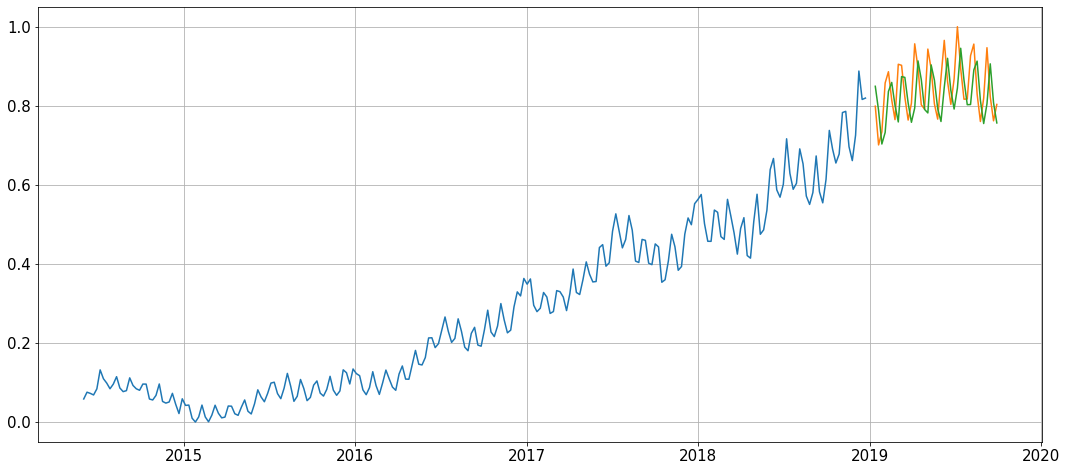

In [ ]:
plt.plot(df_trainY.index, df_trainY.values)
plt.plot(df_testY.index, df_testY.values)
plt.plot(df_testY.index, testPredict,label='pred' )
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

# Skforecast

Попрробуем еще так(тоже как то неочень )

In [ ]:
# !pip install skforecast

In [ ]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

Попробуем библиотеку Skforecast (спойлер предсказания тоже такие себе) 

Train dates : 2014-06-01 00:00:00 --- 2019-02-03 00:00:00  (n=245)
Test dates  : 2019-02-10 00:00:00 --- 2019-10-13 00:00:00  (n=36)


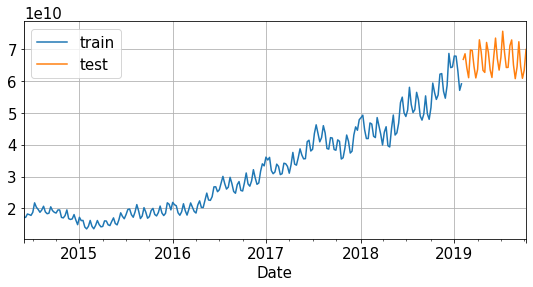

In [ ]:
steps = 36
data_train = dataset1[:-steps]
data_test  = dataset1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['value'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2019-02-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-06 16:11:38 
Last fit date: 2022-10-06 16:11:39 
Skforecast version: 0.5.1 
Python version: 3.7.3 

In [ ]:
# Predictions
# ==============================================================================
steps = 36

predictions = forecaster.predict(steps=steps)

data_test.loc[:, 'pred'] = predictions
data_test.head(15)

/home/irina/Programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,pred
Date,,
2019-02-10,6.674185e+10,6.140721e+10
2019-02-17,6.850709e+10,6.230516e+10
2019-02-24,6.408280e+10,6.099774e+10
2019-03-03,6.099172e+10,6.280820e+10
2019-03-10,6.967669e+10,6.396835e+10
2019-03-17,6.951006e+10,6.536895e+10
2019-03-24,6.452308e+10,6.549136e+10
2019-03-31,6.092624e+10,6.572042e+10
2019-04-07,6.357528e+10,6.544398e+10


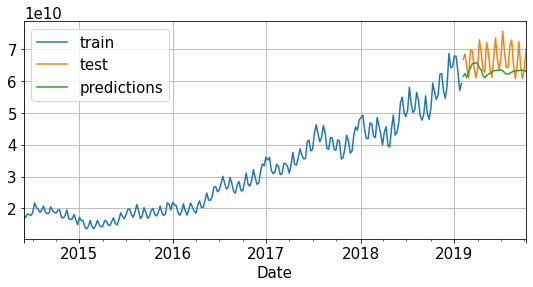

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 3.0806186296482873e+19
Root Mean Squared Error: 5550332088.846835
Mean Absolute Error: 4474661438.167772
R2 -0.8465612232783197


In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 40
             )

forecaster.fit(y=data_train['value'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

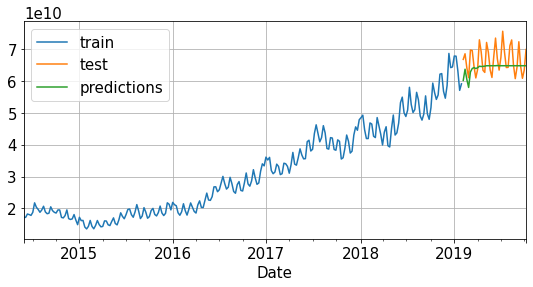

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 2.2553151600134337e+19
Root Mean Squared Error: 4749015855.957352
Mean Absolute Error: 3830738671.193331
R2 -0.3518640316824977


# Обогатим данные

Попробуем обогатить данные и добавить курс $ и € 

In [34]:
dt_d = pd.read_csv('doll.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                  
                   infer_datetime_format="%d/%m/%y")
dt_d

,Doll
Date,
2014-06-02,0.735
2014-06-03,0.734
2014-06-04,0.7343
2014-06-05,0.7343
2014-06-06,0.7332
...,...
2019-12-25,ND
2019-12-26,0.9007
2019-12-27,0.8949


In [43]:
dt_d['Doll'].astype(str).astype(int)

ValueError: ignored

In [42]:
dt_d.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1455 entries, 2014-06-02 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Doll    1455 non-null   object
dtypes: object(1)
memory usage: 22.7+ KB


Сейчас dataset1 идет с шагом неделя, курс с пропусками (без выходных дней)

In [25]:
df_with_currency = pd.concat([dataset, dt_d['Doll']], axis=1)

Данные по курсу только с 2014-06-02, а в наших данных с 2013-12-30, поэтому нужно будет еще отыскать данные по курсу доллара.

In [26]:
df_with_currency = df_with_currency[~df_with_currency.value.isna()]

In [27]:
df_with_currency = df_with_currency[df_with_currency.index > '2014-06-02']

Заполняем пропуски предыдущими значениями - так как пропущенные значения по валюте - это выходные дни, получается, что в выходные дни у нас стоимость доллара сохраняется с пятницы.

In [28]:
df_with_currency.loc[:, 'Doll'] = df_with_currency['Doll'].ffill()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [29]:
df_with_currency

,value,Doll
Date,,
2014-06-03,1.711238e+10,0.734
2014-06-04,1.728287e+10,0.7343
2014-06-05,1.703296e+10,0.7343
2014-06-06,1.723258e+10,0.7332
2014-06-07,1.723258e+10,0.7332
...,...,...
2019-10-06,6.463014e+10,0.9112
2019-10-07,6.611529e+10,0.9104
2019-10-08,6.842405e+10,0.9133


# Лин регрессия 

Попробуем наконец линейную регрессию и градиентный бустинг

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
columns=['Date', 'value']
dt = pd.read_csv('data_1.csv', 
                 parse_dates=['Date'], 
                 dayfirst=True, 
                 header=None, 
                 names=columns)

dt = dt.set_index('Date')
dt = dt.sort_index()

Извлечем фичи из дат

In [ ]:
train_size = int(0.9 * len(dt))
train_size
data_train = dt[:train_size]
data_test  = dt[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2013-12-30 00:00:00 --- 2019-03-18 00:00:00  (n=1899)
Test dates  : 2019-03-19 00:00:00 --- 2019-12-09 00:00:00  (n=212)


In [ ]:
def create_features(dataset1, label=None):
    """
    Creates time series features from datetime index
    """
    dataset1.loc[:, 'date'] = dataset1.index
    dataset1.loc[:, 'dayofweek'] = dataset1['date'].dt.dayofweek
    dataset1.loc[:, 'quarter'] = dataset1['date'].dt.quarter
    dataset1.loc[:, 'month'] = dataset1['date'].dt.month
    dataset1.loc[:, 'year'] = dataset1['date'].dt.year
    dataset1.loc[:, 'dayofyear'] = dataset1['date'].dt.dayofyear
    dataset1.loc[:, 'dayofmonth'] = dataset1['date'].dt.day
    dataset1.loc[:, 'weekofyear'] = dataset1['date'].dt.weekofyear
    
    X = dataset1[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dataset1[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [ ]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,
2019-03-19,1,1,3,2019,78,19,12
2019-03-20,2,1,3,2019,79,20,12
2019-03-21,3,1,3,2019,80,21,12
2019-03-22,4,1,3,2019,81,22,12
2019-03-23,5,1,3,2019,82,23,12
...,...,...,...,...,...,...,...
2019-12-05,3,4,12,2019,339,5,49
2019-12-06,4,4,12,2019,340,6,49
2019-12-07,5,4,12,2019,341,7,49


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_
sorted(list(zip(X_train.columns, importance)), 
       key=lambda x: abs(x[1]))

[('weekofyear', -54766036.211330056),
 ('dayofweek', 105134380.62204275),
 ('quarter', -209591103.1959647),
 ('dayofmonth', 922115192.9580677),
 ('dayofyear', -941436716.310718),
 ('year', 9943552416.505005),
 ('month', 29745663299.969315)]

In [ ]:
pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,29745663299.970001
3,year,9943552416.510000
5,dayofmonth,922115192.960000
0,dayofweek,105134380.620000
6,weekofyear,-54766036.210000
1,quarter,-209591103.200000
4,dayofyear,-941436716.310000


In [ ]:
y_predict = model.predict(X_test)

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 7.079502839174151e+19
Root Mean Squared Error: 8413978154.936077
Mean Absolute Error: 7416085403.630952
R2 -2.2085725961613925


In [ ]:
for_sub = pd.DataFrame(model.predict(X_test), index=X_test.index)
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

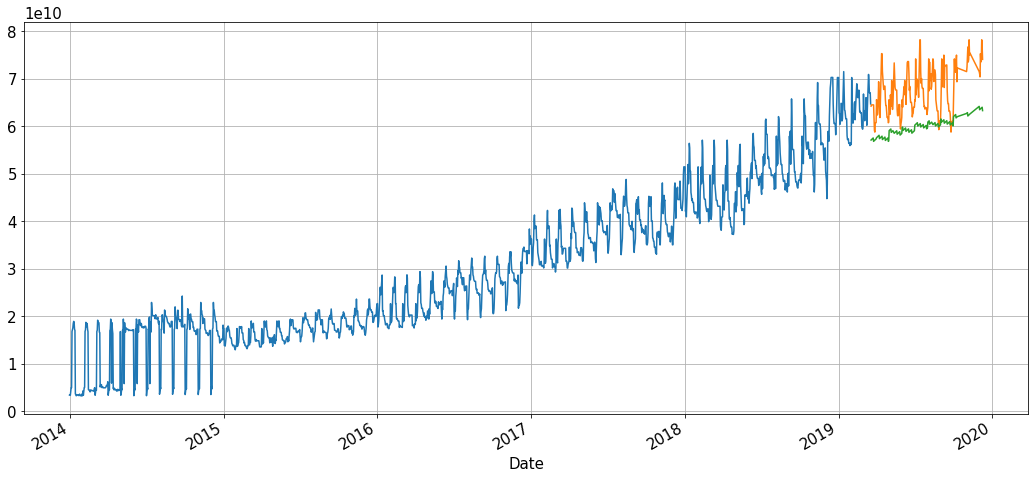

In [ ]:
data_train['value'].plot()
data_test['value'].plot()
for_sub['value_pred'].plot()

In [ ]:
for_sub['value_pred']

Date
2019-03-03    60991721573
2019-03-10    69676689909
2019-03-17    69510062662
2019-03-24    64523082258
2019-03-31    60926240082
2019-04-07    63575284734
2019-04-14    72882377403
2019-04-21    69085776725
2019-04-28    63312433561
2019-05-05    62654309567
2019-05-12    72058349534
2019-05-19    68964875520
2019-05-26    63444894953
2019-06-02    61073057193
2019-06-09    67547721790
2019-06-16    73423986551
2019-06-23    66961447810
2019-06-30    63378883481
2019-07-07    67382286593
2019-07-14    75568693823
2019-07-21    68994476460
2019-07-28    64193930864
2019-08-04    64232431475
2019-08-11    71018575040
2019-08-18    72838591825
2019-08-25    65011646196
2019-09-01    60699040102
Freq: W-SUN, Name: value_pred, dtype: int64

# Лин регрессия 2

In [ ]:
df['trend_plus_resid'] = df['trend'] + df['residual']
df = df[df.trend_plus_resid.notnull()]

df['trend_plus_resid'] = df['trend'] +df['residual']
df = df[df.trend_plus_resid.notnull()]

In [ ]:
df

,value,observed,residual,seasonal,trend,trend_plus_resid,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,
2014-07-13,2.174738e+10,2.174738e+10,2.341995e+09,3.291297e+08,1.907625e+10,2.141825e+10,2014-07-13,6,3,7,2014,194,13,28
2014-07-20,2.036172e+10,2.036172e+10,7.085668e+08,4.580809e+08,1.919507e+10,1.990364e+10,2014-07-20,6,3,7,2014,201,20,29
2014-07-27,1.967819e+10,1.967819e+10,3.390510e+08,8.611252e+07,1.925302e+10,1.959207e+10,2014-07-27,6,3,7,2014,208,27,30
2014-08-03,1.878839e+10,1.878839e+10,-4.511360e+08,-1.248602e+08,1.936438e+10,1.891325e+10,2014-08-03,6,3,8,2014,215,3,31
2014-08-10,1.951300e+10,1.951300e+10,4.318455e+08,-4.467900e+08,1.952795e+10,1.995979e+10,2014-08-10,6,3,8,2014,222,10,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-04,6.423243e+10,6.423243e+10,-3.371717e+09,3.291297e+08,6.727502e+10,6.390330e+10,2019-08-04,6,3,8,2019,216,4,31
2019-08-11,7.101858e+10,7.101858e+10,3.014730e+09,4.580809e+08,6.754576e+10,7.056049e+10,2019-08-11,6,3,8,2019,223,11,32
2019-08-18,7.283859e+10,7.283859e+10,5.431211e+09,8.611252e+07,6.732127e+10,7.275248e+10,2019-08-18,6,3,8,2019,230,18,33


In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

Извлечем фичи из дат

In [ ]:
train_size = int(0.9 * len(df))
train_size
data_train = df[:train_size]
data_test  = df[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2014-07-13 00:00:00 --- 2019-02-24 00:00:00  (n=242)
Test dates  : 2019-03-03 00:00:00 --- 2019-09-01 00:00:00  (n=27)


In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df.loc[:, 'date'] = df.index
    df.loc[:, 'dayofweek'] = df['date'].dt.dayofweek
    df.loc[:, 'quarter'] =df['date'].dt.quarter
    df.loc[:, 'month'] =df['date'].dt.month
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'dayofyear'] = df['date'].dt.dayofyear
    df.loc[:, 'dayofmonth'] = df['date'].dt.day
    df.loc[:, 'weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','observed','residual','seasonal','trend','trend_plus_resid']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_
sorted(list(zip(X_train.columns, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek', 0.0),
 ('weekofyear', -3.3629503025626116e-08),
 ('dayofyear', -2.0768849572919967e-07),
 ('dayofmonth', 2.653775545921381e-07),
 ('quarter', 2.7233830035555684e-06),
 ('year', 5.12395381215283e-06),
 ('month', 5.795529732897373e-06),
 ('trend', 0.12500000010326875),
 ('residual', 0.12500000010326937),
 ('trend_plus_resid', 0.24999999990883032),
 ('seasonal', 0.3750000000120993),
 ('observed', 0.6249999999879012)]

In [ ]:
pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
7,observed,0.620000
9,seasonal,0.380000
11,trend_plus_resid,0.250000
8,residual,0.130000
10,trend,0.130000
0,dayofweek,0.000000
1,quarter,0.000000
2,month,0.000000
3,year,0.000000
4,dayofyear,-0.000000


In [ ]:
y_predict = model.predict(X_test)
y_predict

array([6.09917216e+10, 6.96766899e+10, 6.95100627e+10, 6.45230823e+10,
       6.09262401e+10, 6.35752847e+10, 7.28823774e+10, 6.90857767e+10,
       6.33124336e+10, 6.26543096e+10, 7.20583495e+10, 6.89648755e+10,
       6.34448950e+10, 6.10730572e+10, 6.75477218e+10, 7.34239866e+10,
       6.69614478e+10, 6.33788835e+10, 6.73822866e+10, 7.55686938e+10,
       6.89944765e+10, 6.41939309e+10, 6.42324315e+10, 7.10185750e+10,
       7.28385918e+10, 6.50116462e+10, 6.06990401e+10])

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))


Mean Squared Error: 2.9103830456733704e-10
Root Mean Squared Error: 1.7059844799040144e-05
Mean Absolute Error: 1.5541359230324075e-05
R2 1.0


In [ ]:
for_sub = pd.DataFrame(model.predict(X_test), index=X_test.index)
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

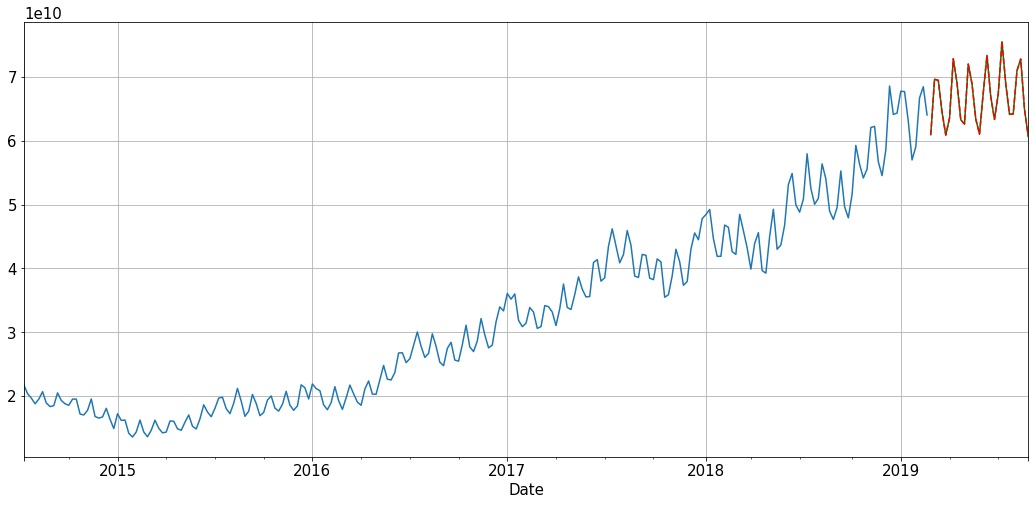

In [ ]:
data_train['value'].plot()
data_test['value'].plot(style='g',label='pred')
for_sub['value_pred'].plot(style='r--',label='pred')

In [ ]:
for_sub['value_pred'].min()

60699040102

Победа? или я что то не так сделал?

Как предсказать на 1 месяц вперед?? Чтобы выделить границы эти..

# xgboost

In [ ]:
dataset1

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


In [ ]:
# !pip install xgboost

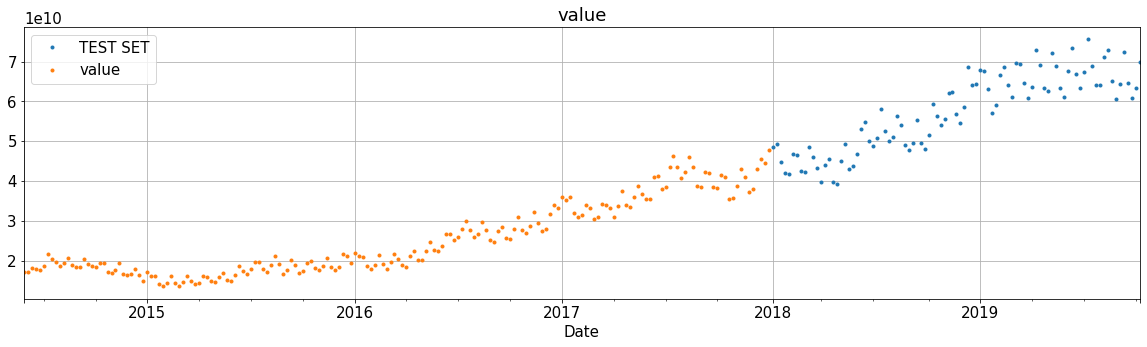

In [ ]:
temp = dataset1[['value']]
split_date = '2018-01'
temp_train = temp.loc[temp.index <= split_date].copy()
temp_test = temp.loc[temp.index > split_date].copy()
_ = temp_test.rename(columns={'value': 'TEST SET'})\
    .join(temp_train.rename(columns={'valueP': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='value', style='.')

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:24054062501.48547	validation_1-rmse:48806124433.37785
[1]	validation_0-rmse:17037112346.71127	validation_1-rmse:35781216510.20492
[2]	validation_0-rmse:12111533027.93495	validation_1-rmse:26658429363.51761
[3]	validation_0-rmse:8684651823.07246	validation_1-rmse:20682717765.01578
[4]	validation_0-rmse:6280807070.18315	validation_1-rmse:16186023139.13387


/home/irina/Programs/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:4629468589.07896	validation_1-rmse:13038148074.76333
[6]	validation_0-rmse:3473401209.89587	validation_1-rmse:10840401193.82915
[7]	validation_0-rmse:2677530205.34323	validation_1-rmse:9115816680.28273
[8]	validation_0-rmse:2158285125.78439	validation_1-rmse:7995416496.23680
[9]	validation_0-rmse:1801804443.71650	validation_1-rmse:7388805879.27256
[10]	validation_0-rmse:1564168394.66833	validation_1-rmse:7004747879.34599
[11]	validation_0-rmse:1410712794.50336	validation_1-rmse:6559999032.14133
[12]	validation_0-rmse:1277125949.89281	validation_1-rmse:6422740148.11826
[13]	validation_0-rmse:1195222750.57864	validation_1-rmse:6241148558.19976
[14]	validation_0-rmse:1119732802.62895	validation_1-rmse:6172473387.79352
[15]	validation_0-rmse:1046507232.30690	validation_1-rmse:6096589593.03510
[16]	validation_0-rmse:1007265858.92702	validation_1-rmse:6053296798.68236
[17]	validation_0-rmse:952540204.01566	validation_1-rmse:6021222353.57196
[18]	validation_0-rmse:922946

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [ ]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

2.287923389380372e+19

In [ ]:
y_pred

array([6.5198195e+10, 6.3852110e+10, 6.2143308e+10, 6.2034473e+10,
       6.2097129e+10, 6.1625659e+10, 6.0118340e+10, 5.9707843e+10,
       5.9791483e+10, 5.9943973e+10, 5.9908043e+10, 6.0262502e+10,
       5.9953140e+10, 6.8263776e+10, 6.2203838e+10, 6.2625178e+10,
       6.1833634e+10, 6.3051915e+10, 6.4187785e+10, 6.5689031e+10,
       6.5750548e+10, 6.1651018e+10, 6.4351752e+10, 6.7434893e+10,
       6.7050516e+10, 6.5298604e+10, 6.3976849e+10, 6.4060490e+10,
       6.5359929e+10, 6.4008249e+10, 6.2864585e+10, 6.0905366e+10,
       6.0612182e+10, 6.0643742e+10, 6.0565275e+10, 5.9397644e+10,
       5.9397644e+10, 5.9460301e+10, 6.0930908e+10, 6.1496918e+10,
       6.1833359e+10, 6.7581137e+10, 6.2270767e+10, 6.2527164e+10,
       6.1600256e+10, 6.2438703e+10, 6.3170400e+10, 6.4815755e+10,
       6.5147138e+10, 6.1294678e+10, 6.3966605e+10, 6.9596471e+10,
       6.9365629e+10, 6.7620794e+10, 6.6395935e+10, 6.6395935e+10,
       6.6534584e+10, 6.4904876e+10, 6.3620751e+10, 6.1815054e

In [ ]:
for_sub1 = pd.DataFrame(regressor.predict(X_test))
for_sub1 = for_sub1.rename({0:'value_pred'}, axis=1)

for_sub1.value_pred = for_sub1.value_pred.round().astype('int')
for_sub1

,value_pred
0,65198194688
1,63852109824
2,62143307776
3,62034472960
4,62097129472
...,...
207,62102056960
208,67604930560
209,68796801024
210,68977401856


# Решение Сбера

Как они делают:
1) Логарифмирует - это круто, можно добавить как фичу к твоим моделям, потому что очень много чего в экономике можно описать логарифмической кривой, посмотри график логарифма, он похож как раз на то что есть у тебя\
2) Фильтруют данные - посмотреть простые методы фильтрации уже реализованные в Python, но я не уверена, что это нужно в данном случае, но нужно посмотреть как будет метрика меняться. \
3) Нормализуют/Стандартизируют данные - у тебя было StandartScaler как раз
4) Далее находят тренд, сезонность, остатки (у тебя есть специальная функция для этого seasonal decompouse)\
5) Обучают модель, которая будет предсказывать тренд\
6) Обучают модель, которая будет предсказывать остатки\
7) Функция сезонности имеет конкретный вид $(exp(- (1/(len)^2)* 2*(sin(pi*abs(x-y)/period))^2)$, с seasonal decompouse можно получить табличку, где для каждой даты будет свое значение сезонности\


8) Предсказываем тренд на тествой выборке\
9) Предсказываем остатки на тествой выборке\
10) По дате определеяем коэффициент сезонности\
11) Перемножаем 8-10 и получаем предсказание\


Их решения на R
```
# library(kernlab)
library(dplyr)
library(zoo)

data=read.csv2('data.csv', header = T, stringsAsFactors = F)
data$REPORTDATE = as.Date(data$REPORTDATE,format = '%d.%m.%Y')

#Логарифмируем объемы

data$VALUE = log(data$VALUE)

#Функция расчета стабильной части на дату

stableOnDate = function(report_date, data){
  
  
  h  = 366
  t = report_date + -h:365
  
  
  
  df = filter(data, REPORTDATE > report_date - h, REPORTDATE <= report_date)
  
  #масштабируем данные
  y  = df$VALUE; my = mean(y) ; sdy = sd(y);   y = (y - my)/sdy
  
  
  x_and_xpredict = 1:(h+365) 
  
  
  L = length(x_and_xpredict)
  
  
  
  
  
  
  
  trend    = function(x,y)   1/(x+365) * 1/(y+365)
  seasonRBF = function(len,period) function(x,y) exp(- (1/(len)^2)* 2*(sin(pi*abs(x-y)/period))^2  )
  
  #Применить функцию к попарным значениям
  makeMat   = function(x,fun) outer(x,x,fun)
  
  #Масштабируем матрицу тренда
  Ktrend   = makeMat(x_and_xpredict,trend) ; Ktrend = (Ktrend - mean(Ktrend)); Ktrend = (Ktrend)/max(Ktrend)
  Season  = function(x,f)   makeMat(x_and_xpredict,seasonRBF(1,x) )
  
  
  
  
  
  
  M  = 1:h
  M2 = 1:L ; M2 = M2[!M2 %in% M]
  
  
  
  makeFitandPredict = function(K,y,q){
    
    K_train = K[M,M] ; class(K_train) <- "kernelMatrix"
    K_pred  = K[M2,M] ; class(K_pred) <- "kernelMatrix"
    model   = kqr(K_train,y,tau=q)
    fit     = predict(model,K_train)
    pred    = predict(model,K_pred) 
    list(fit = fit,pred = pred)
  }
  
  
  K    =  1e2*Ktrend   + diag(0.1,L,L)
  res  =  makeFitandPredict(K,y,0.01)
  
  
  pred = res$pred 
  fit  = res$fit
  
  residuals = y - fit
  
  
  K    =    1e2*Season(365) + diag(0.1,L,L) 
  res2 =    makeFitandPredict(K,residuals,0.01)
  
  
  pred = res2$pred + pred 
  fit  = res2$fit + fit
  
  
  
  #Обратное масштабирование
  pred = pred*sdy  + my
  fit  = fit*sdy   + my
  
  
  #Бакеты
  ts      = seq(365/12,365,365/12)
  
  #Посчитаем для каждого бакета стабильную часть
  stable_levels = lapply(ts,function(t) c(last(df$VALUE),head(pred,t))%>% min)
  stable_levels = as.numeric(stable_levels)
  names = c('1m','2m','3m','4m','5m','6m','7m','8m','9m','10m','11m','12m')
  
  
  
  res   = data.frame(report_date = report_date,
                     bucket = names,
                     stable = stable_levels
  )
  
  
}








#Факт стабильной части на дату на горизонте h, на дату report_date
stablesFact = function(h,report_date,data=data){
  df = filter(data,REPORTDATE <= report_date+h, REPORTDATE >= report_date)
  min(df$VALUE)
}
  


#Cравниваем

t = as.Date('2018-08-23')
model = stableOnDate(t,data)

stab31 = stablesFact(31,t,data) %>% exp

model31 = filter(model, bucket == '1m')$stable %>% exp

```


  




In [ ]:
data=dataset1
data

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


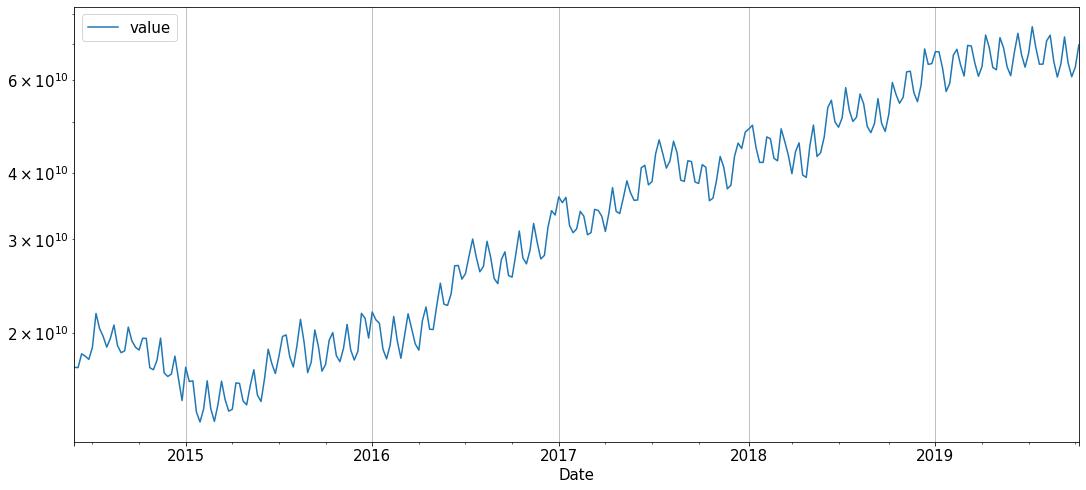

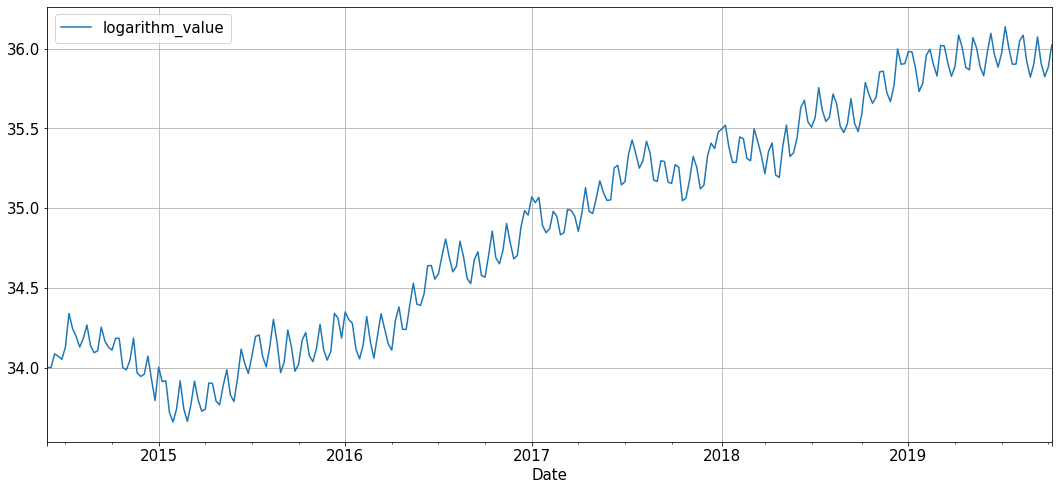

In [ ]:
from matplotlib import pyplot
data.plot(y='value')
pyplot.yscale('log')
pyplot.show()
data['logarithm_value'] = np.log2(data['value'])
data.plot(y='logarithm_value')


In [ ]:
object = StandardScaler()
object.fit_transform(data)


array([[-1.06083812e+00, -1.21741273e+00],
       [-1.06195718e+00, -1.21970012e+00],
       [-1.00203620e+00, -1.10078725e+00],
       [-1.01246640e+00, -1.12097995e+00],
       [-1.02655026e+00, -1.14857654e+00],
       [-9.72440044e-01, -1.04458447e+00],
       [-8.04715514e-01, -7.53068857e-01],
       [-8.82877420e-01, -8.83608860e-01],
       [-9.21434043e-01, -9.51313077e-01],
       [-9.71625656e-01, -1.04306026e+00],
       [-9.30751660e-01, -9.68027315e-01],
       [-8.64917823e-01, -8.52844621e-01],
       [-9.64922826e-01, -1.03055949e+00],
       [-9.97017583e-01, -1.09114409e+00],
       [-9.88523249e-01, -1.07492852e+00],
       [-8.75221139e-01, -8.70435471e-01],
       [-9.42364027e-01, -9.89057121e-01],
       [-9.71842843e-01, -1.04346663e+00],
       [-9.85107486e-01, -1.06844507e+00],
       [-9.30228680e-01, -9.67085435e-01],
       [-9.30536300e-01, -9.67639400e-01],
       [-1.06233716e+00, -1.22047741e+00],
       [-1.07091221e+00, -1.23810016e+00],
       [-1.

In [ ]:
def stableOnDate(report_date, data):
  h  = 366
  t = report_date + (-h/365)
  df = filter(data, REPORTDATE > report_date - h, REPORTDATE <= report_date)
  y  = df['value']
  my = mean(y) 
  sdy = sd(y)
  y = (y - my)/sdy
  x_and_xpredict = 1/(h+365) 
  L = len(x_and_xpredict)

  def trend(x,y): 
      1/(x+365) * 1/(y+365)

  def  seasonRBF(len,period):   
    exp(- (1/(len)^2)* 2*(sin(pi*abs(x-y)/period))^2  )
  

  def  makeMat(x,fun):
    outer(x,x,fun)

  #Применить функцию к попарным значениям

  #Масштабируем матрицу тренда
  Ktrend   = makeMat(x_and_xpredict,trend) ; 
  Ktrend = (Ktrend - mean(Ktrend));
  Ktrend = (Ktrend)/max(Ktrend)
  def   Season(x,f):
    makeMat(x_and_xpredict,seasonRBF(1,x) )

  M  = 1/h
  M2 = 1/L 
  #M2 = M2[!M2 %in% M] ???

  #....


In [ ]:
import statsmodels.api as sm
sm = sm.tsa.SARIMAX(
    df_train_S.trend, 
    order=(3,1,2) # to be tuned/optimized in a future article
) 
res = sm.fit()


In [ ]:
import statsmodels.api as sm
sm_r = sm.tsa.SARIMAX(
    df_train_S.residual	, 
    order=(1,0,0) # to be tuned/optimized in a future article
) 
res_r = sm_r.fit()

In [ ]:
# Make trend forecast
df_test_S['residual_predict'] = res_r.predict(
    start=np.min( df_test_S.index), 
    end=np.max(df_test_S.index)
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_test_S

,value,observed,residual,seasonal,trend,trend_plus_resid,pred,residual_predict
Date,,,,,,,,
2019-05-26,6.344489e+10,6.344489e+10,-3.477723e+09,8.611252e+07,6.683651e+10,6.335878e+10,6.232079e+10,4.700901e-04
2019-06-02,6.107306e+10,6.107306e+10,-5.679539e+09,-1.248602e+08,6.687746e+10,6.119792e+10,5.991039e+10,1.175651e-04
2019-06-09,6.754772e+10,6.754772e+10,6.101817e+08,-4.467900e+08,6.738433e+10,6.799451e+10,6.824427e+10,2.940194e-05
2019-06-16,7.342399e+10,7.342399e+10,5.607538e+09,1.312153e+08,6.768523e+10,7.329277e+10,7.051774e+10,7.353151e-06
2019-06-23,6.696145e+10,6.696145e+10,-3.112729e+08,-1.505831e+08,6.742330e+10,6.711203e+10,6.501986e+10,1.838954e-06
2019-06-30,6.337888e+10,6.337888e+10,-3.489182e+09,-3.147291e+08,6.718279e+10,6.369361e+10,6.014138e+10,4.599053e-07
2019-07-07,6.738229e+10,6.738229e+10,-3.694627e+08,9.197979e+07,6.765977e+10,6.729031e+10,6.445840e+10,1.150180e-07
2019-07-14,7.556869e+10,7.556869e+10,7.154445e+09,1.989678e+08,6.821528e+10,7.536973e+10,7.016113e+10,2.876493e-08
2019-07-21,6.899448e+10,6.899448e+10,1.076478e+09,-1.760293e+08,6.809403e+10,6.917051e+10,6.728975e+10,7.193839e-09


In [ ]:
# Make trend forecast
df_test_S['trend_prediction'] = res.predict(
    start=np.min( df_test_S.index), 
    end=np.max(df_test_S.index)
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_test_S

,value,observed,residual,seasonal,trend,trend_plus_resid,pred,residual_predict,trend_prediction
Date,,,,,,,,,
2019-05-26,6.344489e+10,6.344489e+10,-3.477723e+09,8.611252e+07,6.683651e+10,6.335878e+10,6.232079e+10,4.700901e-04,6.254747e+10
2019-06-02,6.107306e+10,6.107306e+10,-5.679539e+09,-1.248602e+08,6.687746e+10,6.119792e+10,5.991039e+10,1.175651e-04,6.254814e+10
2019-06-09,6.754772e+10,6.754772e+10,6.101817e+08,-4.467900e+08,6.738433e+10,6.799451e+10,6.824427e+10,2.940194e-05,6.254802e+10
2019-06-16,7.342399e+10,7.342399e+10,5.607538e+09,1.312153e+08,6.768523e+10,7.329277e+10,7.051774e+10,7.353151e-06,6.254857e+10
2019-06-23,6.696145e+10,6.696145e+10,-3.112729e+08,-1.505831e+08,6.742330e+10,6.711203e+10,6.501986e+10,1.838954e-06,6.254835e+10
2019-06-30,6.337888e+10,6.337888e+10,-3.489182e+09,-3.147291e+08,6.718279e+10,6.369361e+10,6.014138e+10,4.599053e-07,6.254881e+10
2019-07-07,6.738229e+10,6.738229e+10,-3.694627e+08,9.197979e+07,6.765977e+10,6.729031e+10,6.445840e+10,1.150180e-07,6.254854e+10
2019-07-14,7.556869e+10,7.556869e+10,7.154445e+09,1.989678e+08,6.821528e+10,7.536973e+10,7.016113e+10,2.876493e-08,6.254896e+10
2019-07-21,6.899448e+10,6.899448e+10,1.076478e+09,-1.760293e+08,6.809403e+10,6.917051e+10,6.728975e+10,7.193839e-09,6.254866e+10


Каким методом прогнозировть тренд, зезонность 